# Residual Network With Pytorch Lightning

Topics:
1. About Dataset
2. Install and Load Library
3. Data processing
4. Residual Network Architecture
5. Train Model
6. Save Model
7. Load Model and Predict

## About Dataset

#### LungVision

Contains PNG images of Normal, Pneumonia and Tuberculosis Lungs

The images are in PNG format. The resolution of the images are 512x512.

The dataset has been divided into train,test and val set.

The lung images dataset is a comprehensive collection of images used for the training and evaluation of deep-learning models for the diagnosis of lung infections. The dataset contains a total of 17,275 images, consisting of 10,406 normal images, 5,775 pneumonia images, and 1,094 tuberculosis infected images. The images were sourced from multiple locations, including RSNA, Montgomery County chest X-ray set, Shenzhen chest X-ray, Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh, and their collaborators. The original images were in the DCM format, and they were converted to the Png format to ensure compatibility with deep learning models. This dataset is an essential resource for researchers, clinicians, and data scientists working on lung infection diagnosis, and it provides a valuable tool for the development of advanced AI models for lung disease diagnosis.

Dataset Link: [Dataset LungVision](https://www.kaggle.com/datasets/amitpant7/lungvision/data)

## Install and Load Library

In [ ]:
# install
!pip install pytorch-lightning --quiet
!pip install torchmetrics --quiet
!pip install torchsummary --quiet
!pip install visualtorch --quiet

In [ ]:
# load
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR


from torchvision import transforms
from torchvision.datasets import ImageFolder

from torchsummary import summary

import torchmetrics

import visualtorch
from collections import defaultdict

from PIL import Image


## Data processing

In [ ]:
# data path
data_dir = '/teamspace/studios/this_studio/dataset/dataset'
test_path = data_dir + '/test'
train_path = data_dir + '/train'
val_path = data_dir + '/val'

# dataset class
os.listdir(train_path)

['normal', 'pnemo', 'tb']

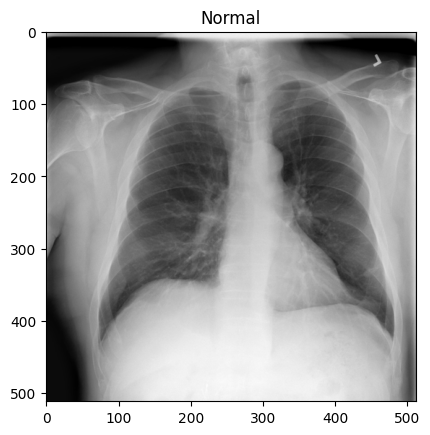

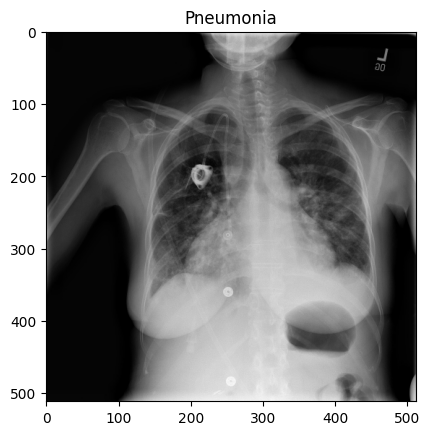

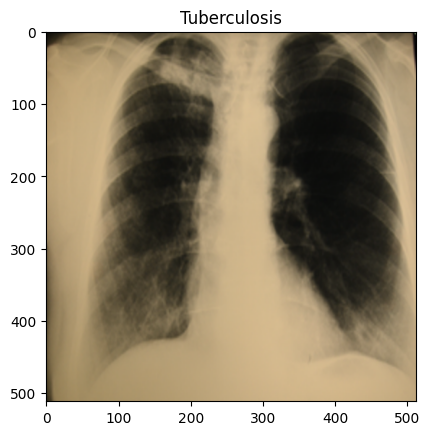

In [ ]:
img_normal = cv2.imread(train_path + '/normal/Normal-2.png')
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2RGB)
plt.title('Normal')
plt.imshow(img_normal)
plt.show()

img_pnemo = cv2.imread(train_path + '/pnemo/0a9fd225-a33a-47de-849e-156933b21296.png')
plt.title('Pneumonia')
plt.imshow(img_pnemo)
plt.show()

img_tuberculosis = cv2.imread(train_path + '/tb/Tuberculosis-2.png')
plt.title('Tuberculosis')
plt.imshow(img_tuberculosis)
plt.show()

In [ ]:
# dataset class len
print(f'normal : {len(os.listdir(train_path + "/normal"))}')
print(f'pnemo : {len(os.listdir(train_path + "/pnemo"))}')
print(f'tb : {len(os.listdir(train_path + "/tb"))}')

normal : 5256
pnemo : 4042
tb : 765


In [ ]:
# image size
img_normal.shape, img_pnemo.shape, img_tuberculosis.shape

((512, 512, 3), (512, 512, 3), (512, 512, 3))

In [ ]:
# create transforms
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# train , test
train_dataset = ImageFolder(train_path, transform=train_transforms)
val_dataset = ImageFolder(val_path, transform=val_transforms)
test_dataset = ImageFolder(test_path, transform=val_transforms)

In [ ]:
# loader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# label class
train_dataset.classes

['normal', 'pnemo', 'tb']

## Residual Network Architecture

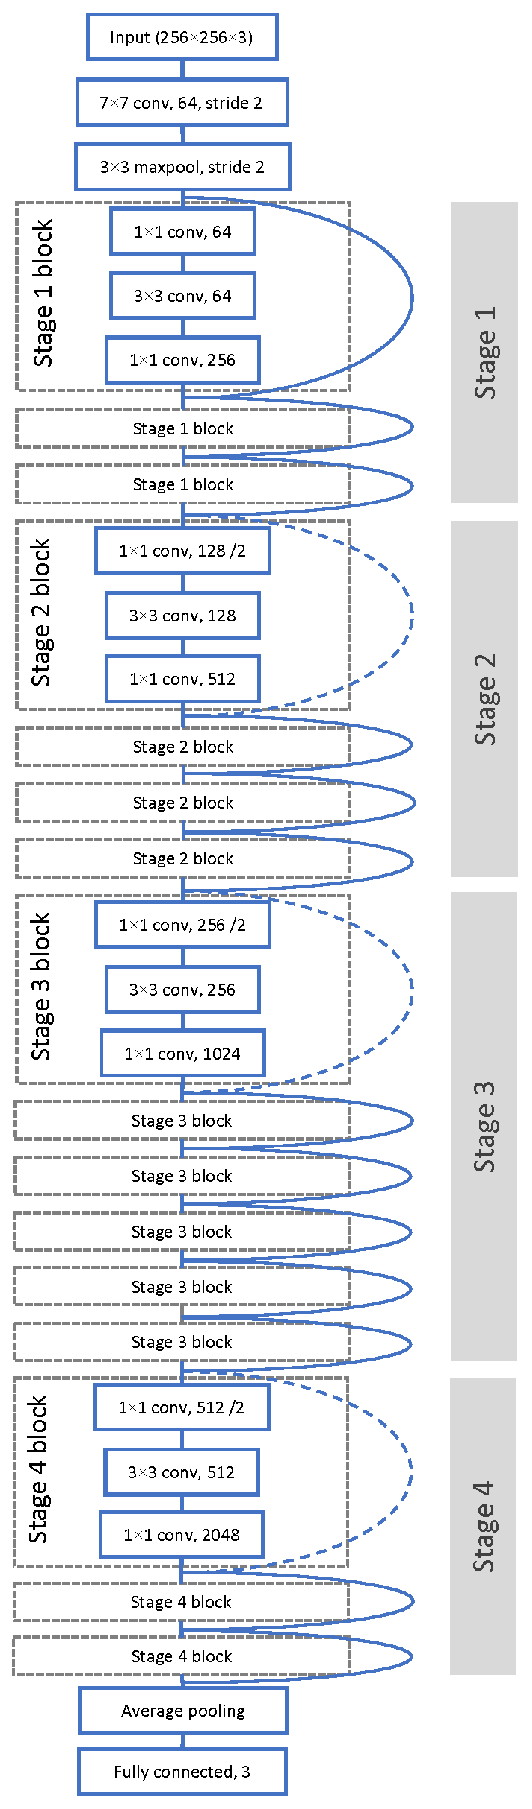

In [ ]:
# residualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity=None, stride=1):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels*4,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels*4)
        )

        self.identity = identity
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        identity_1 = x.clone()

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        if self.identity is not None:
            identity_1 = self.identity(identity_1)

        x += identity_1
        x = self.relu(x)
        return x

In [ ]:
# residual network with pytorch lightning

class ResidualNetwork(pl.LightningModule):
    def __init__(self, learning_rate, batch_size, block, layers):
        super().__init__()

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=3)
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(0.2)
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
          )

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((16, 16))
        self.fc = nn.Linear(512*16*16*4, 3)



    def _make_layer(self, block, num_blocks, out_channels, stride):
        identity = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*4:
          identity = nn.Sequential(
              nn.Conv2d(
                  in_channels=self.in_channels,
                  out_channels=out_channels*4,
                  kernel_size=1,
                  stride=stride,
                  bias=False
              ),
              nn.BatchNorm2d(out_channels*4)
          )

        layers.append(block(self.in_channels, out_channels, identity, stride))
        self.in_channels = out_channels*4

        for i in range(num_blocks - 1):
          layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        return test_loader



    def forward(self, x):
      x = self.conv1(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)
      x = nn.Flatten()(x)
      x = self.fc(x)
      return x


    def _common_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.accuracy(logits, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'train_loss': loss, 'train_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'val_loss': loss, 'val_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'test_loss': loss, 'test_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss


    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        return logits


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        return optimizer


## Train Model

In [ ]:
device = torch.device('cuda')
bacha_size = 32
model = ResidualNetwork(
    learning_rate=0.01,
    batch_size=bacha_size,
    block=ResidualBlock,
    layers=[3, 5, 21, 5]
).to(device)

# tensorboard
logger = TensorBoardLogger('lightning_logs', name='tensorboard')

In [ ]:
# torchsummary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

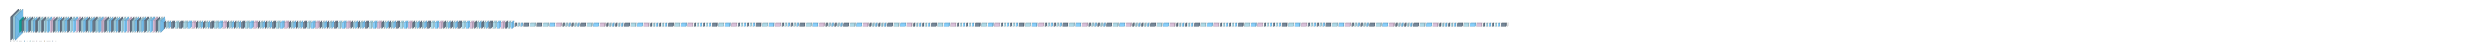

In [ ]:
# visual model
input_shape = (1, 3, 512, 512)

color_map: dict = defaultdict(dict)
color_map[nn.Conv2d]["fill"] = "LightSlateGray"  # Light Slate Gray
color_map[nn.ReLU]["fill"] = "#87CEFA"  # Light Sky Blue
color_map[nn.MaxPool2d]["fill"] = "LightSeaGreen"  # Light Sea Green
color_map[nn.Flatten]["fill"] = "#98FB98"  # Pale Green
color_map[nn.Linear]["fill"] = "LightSteelBlue"  # Light Steel Blue

img = visualtorch.layered_view(model, input_shape=input_shape, color_map=color_map,
                               one_dim_orientation="x", spacing=40, legend=True)

plt.figure(figsize=(25, 20))
plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

In [ ]:
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", filename='best-checkpoint', save_top_k=1)
# lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")

In [ ]:
class MyPrintingCallback(pl.Callback):
    def __init__(self):
        super().__init__()
    def on_train_start(self, trainer, pl_module):
        print("Starting training!")
    def on_train_end(self, trainer, pl_module):
        print("Finished training")

In [ ]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=20,
    logger=logger,
    callbacks=[MyPrintingCallback(), checkpoint, EarlyStopping('val_loss')],
    profiler='simple'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory lightning_logs/tensorboard/version_28/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | accuracy           | MulticlassAccuracy | 0      | train
1 | cross_entropy_loss | CrossEntropyLoss   | 0      | train
2 | dropout            | Dropout            | 0      | train
3 | conv1              | Sequential         | 9.6 K  | train
4 | layer1             | Sequential         | 215 K  | train
5 | layer2             | Sequential         | 1.5 M  | train
6 | layer3             | Sequential         | 23.9 M | train
7 | layer4             | Sequential         | 23.9 M | train
8 | avgpool            | AdaptiveAvgPool2d  | 0      | train
9 | fc                 | Linear             | 1.6 M  | train
---

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Starting training!


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Finished training


FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -       

In [ ]:
trainer.validate()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at lightning_logs/tensorboard/version_28/checkpoints/best-checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs/tensorboard/version_28/checkpoints/best-checkpoint.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.81210857629776      │
│         val_loss          │    0.47878116369247437    │
└───────────────────────────┴───────────────────────────┘

VALIDATE Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -  

[{'val_loss': 0.47878116369247437, 'val_acc': 0.81210857629776}]

In [ ]:
trainer.test()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at lightning_logs/tensorboard/version_28/checkpoints/best-checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs/tensorboard/version_28/checkpoints/best-checkpoint.ckpt
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve perfor

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8029146194458008     │
│         test_loss         │    0.49482569098472595    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -      

[{'test_loss': 0.49482569098472595, 'test_acc': 0.8029146194458008}]

In [ ]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
print(trainer.callback_metrics)

{'test_loss': tensor(0.4948), 'test_acc': tensor(0.8029)}


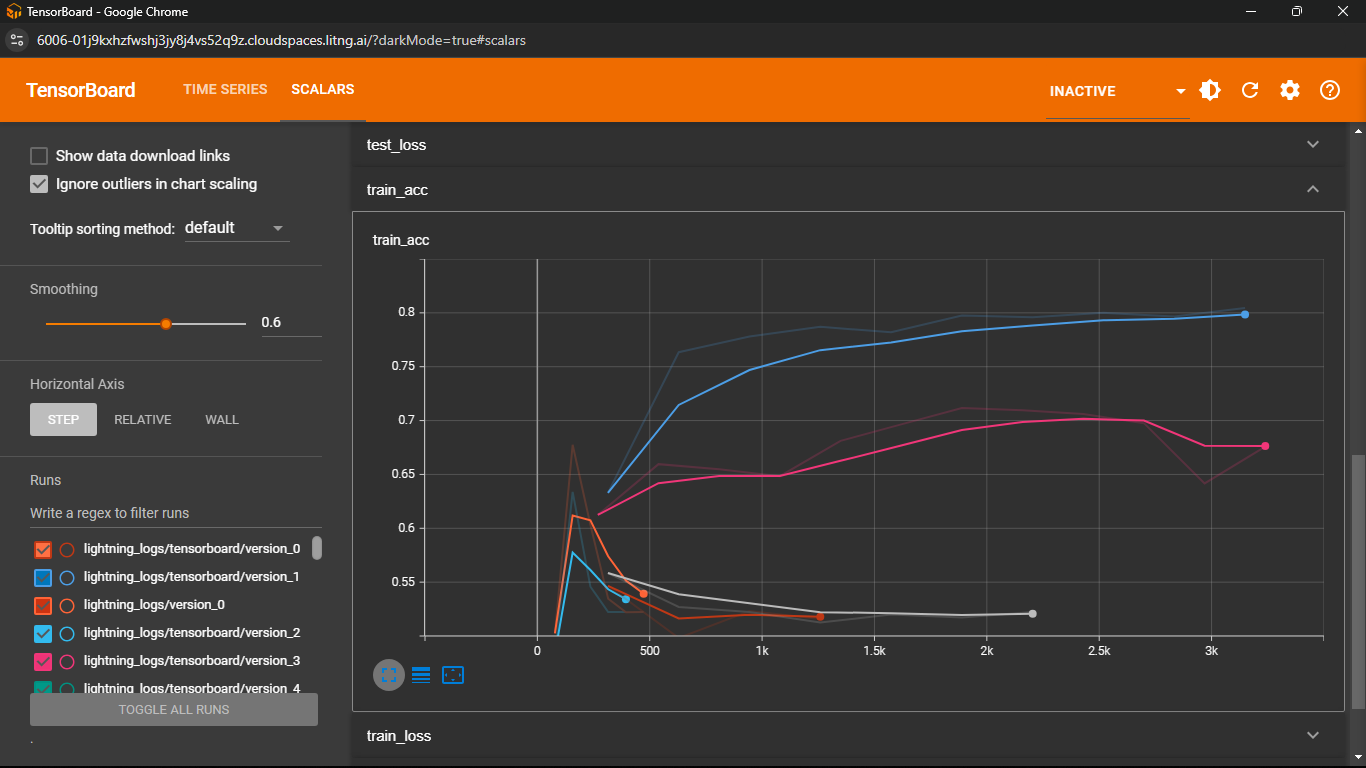

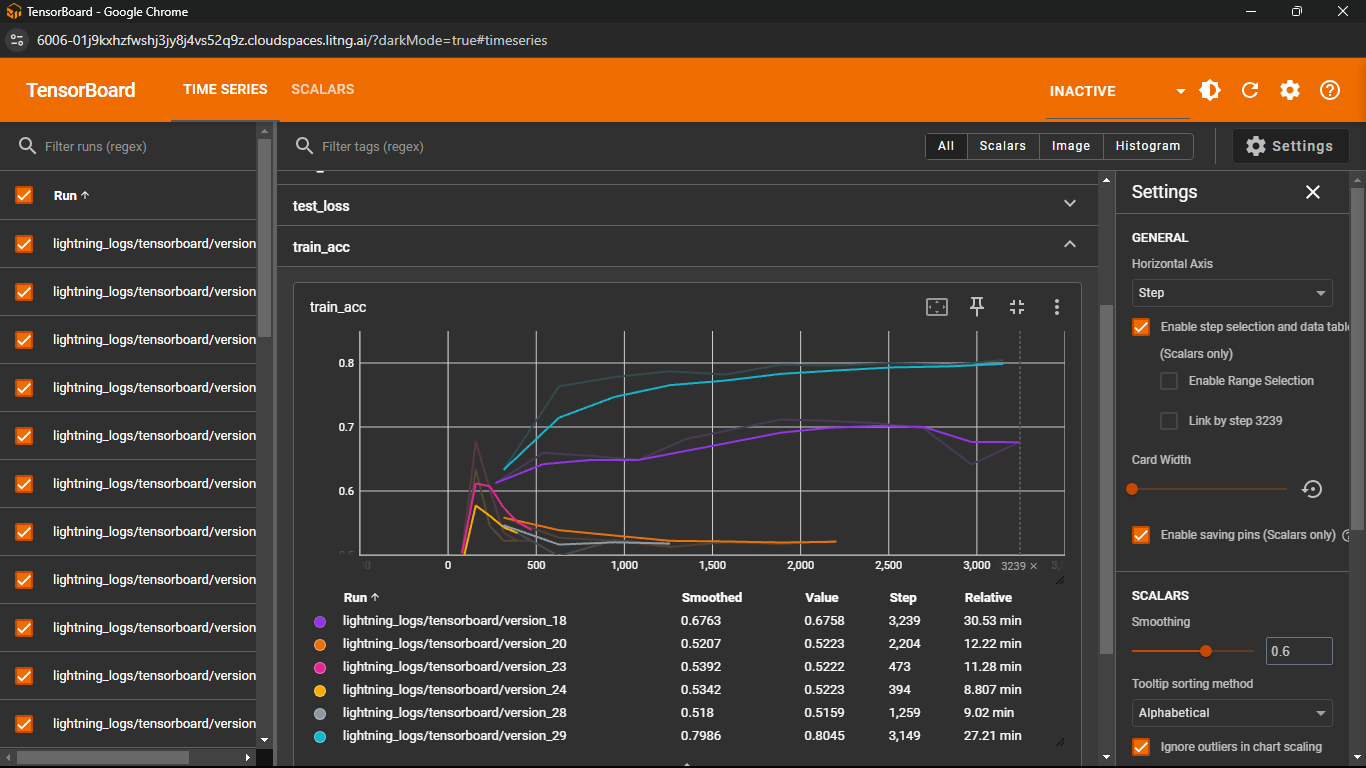

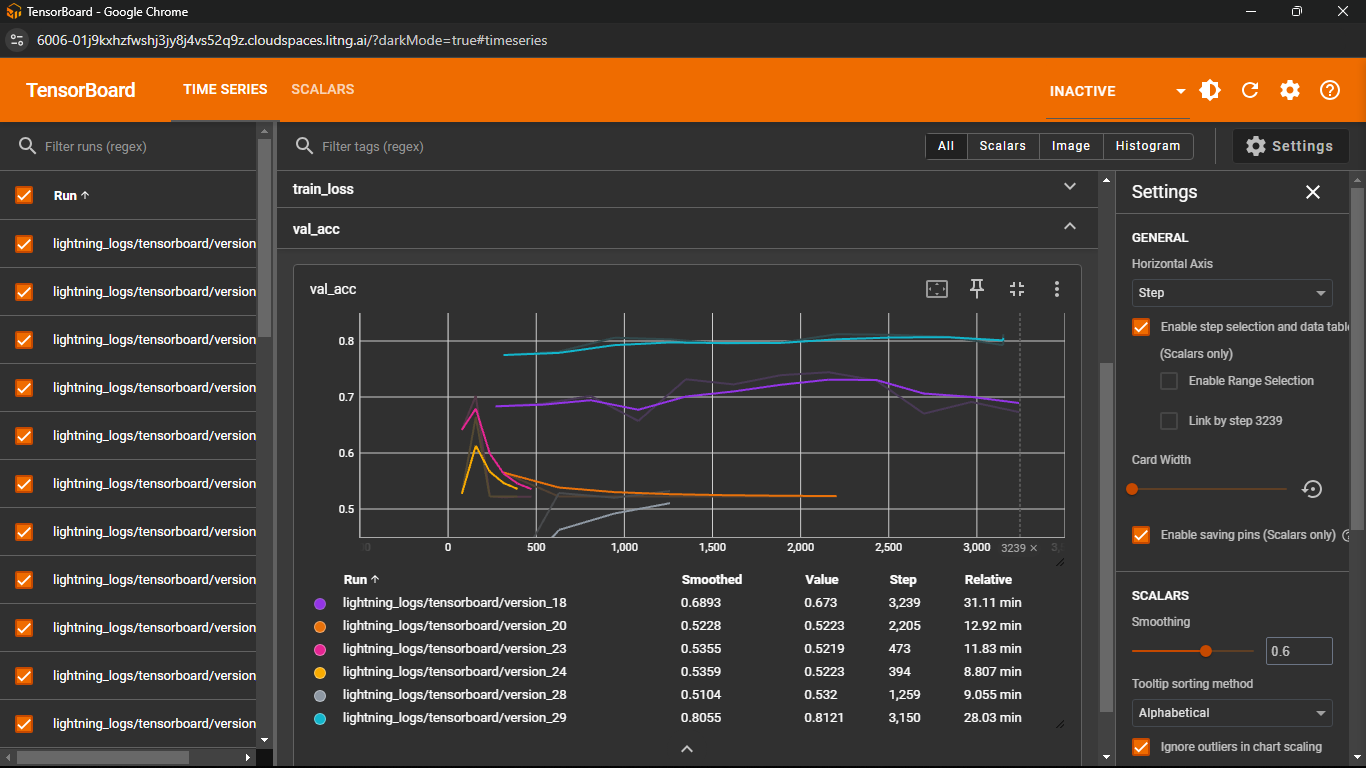

## Save Model

In [ ]:
# best checkpoint
pretrain_model = ResidualNetwork.load_from_checkpoint(batch_size=bacha_size, learning_rate=0.001,
                                                      block=ResidualBlock,
                                            layers=[3, 5, 21, 5],
                                          checkpoint_path=checkpoint.best_model_path)
pretrain_model = pretrain_model.to('cuda')
pretrain_model.eval()
pretrain_model.freeze()

In [ ]:
# save model
model = ResidualNetwork.load_from_checkpoint(batch_size=bacha_size, learning_rate=0.001,
                                             block=ResidualBlock,
                                            layers=[3, 5, 21, 5],
                                          checkpoint_path=checkpoint.best_model_path)
torch.save(model.state_dict(), 'ResidualNetwork104-pytorch-lightning.pt')